# A comparison on how the cRBM and the cRTRBM explain the underlying structure and dynamics in zebrafish surrogate data

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from tqdm import tqdm
import h5py
plt.rcParams['figure.figsize'] = [8, 5]

import sys
sys.path.append(r'/home/sebastian/Desktop/rtrbm_master/')

from utils.plots import * 
from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM
from utils.funcs import *
from utils.visualize_hidden_network import *
from utils.create_param_class import Parameters


import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
#torch.cuda.set_device(1)
torch.cuda.current_device()

ModuleNotFoundError: No module named 'utils'

## Import zebrafish surrogate data, train cRBM and cRTRBM and save the parameters


In [2]:
# initialize class to save parameters
cRBM_parameters = Parameters()
cRTRBM_parameters = Parameters()

# define number of hiddens and epochs  
N_H = 30
n_epochs = 100  
num_data_sets = 5

for i in tqdm(range(1,num_data_sets+1)):
    
    # import data
    data = h5py.File('/mnt/data/zebrafish/chen2018/subject_artificial/subject_'+str(i)+'/Deconvolved/subject_'+str(i)+'_spikes.h5', 'r')

    # define coordinates and spikes
    spikes = torch.tensor(data['Data']['spikes'])
    xyz = torch.tensor(data['Data']['coordinates'])

    # disregard neurons that dont fire 
    xyz = xyz[torch.sum(spikes,1)!=0, :]
    spikes = spikes[torch.sum(spikes,1)!=0, :]

    # reduce dataset by taking voxels
    [voxel_spike, voxel_xyz] =  make_voxel_xyz(n = 25, spikes = spikes, xyz = xyz , mode = 1, fraction = 0.1, disable_tqdm = True)

    # make the spiking behaviour binairy
    spike_thres = torch.sort(voxel_spike.ravel(), descending=True)[0][int(np.ceil(0.15*(voxel_spike.shape[0]*voxel_spike.shape[1])))]
    voxel_spike[voxel_spike<=spike_thres] = 0
    voxel_spike[voxel_spike>spike_thres] = 1
    N_V, T = voxel_spike.shape

    # reshape to train in batches
    mini_batch_size = 128

    # notice that round makes it possible to have batch_size*nr_batches > spikes.shape[1] if this happens just add -1
    nr_batches = (voxel_spike.shape[1] // mini_batch_size)
    voxel_spike = voxel_spike[:,:mini_batch_size*nr_batches]
    V = torch.zeros([voxel_spike.shape[0], mini_batch_size, nr_batches])

    for j in range(nr_batches):
        V[:,:,j] =  voxel_spike[:, mini_batch_size*j:mini_batch_size*(j+1)]
        

    # transfer dataset to cudo GPU:0
    torch.cuda.set_device(0)
    device='cuda:0'
    voxel_spike = voxel_spike.clone().detach().to(device)

    # define cRBM and train on GPU:0
    cRBM = RBM(voxel_spike, N_H=N_H, device = device)
    cRBM.learn(n_epochs=n_epochs, lr=1e-4, sp=3e-4, x=1, batchsize= 1, disable_tqdm = True)

    # Safe parameters & coordinates
    cRBM.params = [cRBM.W, cRBM.b_V, cRBM.b_H, cRBM.errors, voxel_spike, voxel_xyz, spike_thres] 
    cRBM_parameters.add_params(cRBM)


    # transfer dataset in batches to cudo GPU:1
    torch.cuda.set_device(1)
    device='cuda:1'
    V = V.clone().detach().to(device)

    # define cRTRBM and train on GPU:1
    cRTRBM = RTRBM(V, N_H=N_H, device = device)
    cRTRBM.learn(n_epochs=n_epochs, lr=1e-4, sp=3e-5, x=2, batchsize=1, disable_tqdm = True)

    # Safe parameters & coordinates
    cRTRBM.params = [cRTRBM.W, cRTRBM.W_acc, cRTRBM.b_V, cRTRBM.b_H, cRTRBM.b_init, cRTRBM.errors, voxel_spike, voxel_xyz, spike_thres] 
    cRTRBM_parameters.add_params(cRTRBM)


100%|██████████| 5/5 [55:06<00:00, 661.24s/it]


##  VH, spikes grouped by strongest connecting HU and hidden unit activity of the cRBM

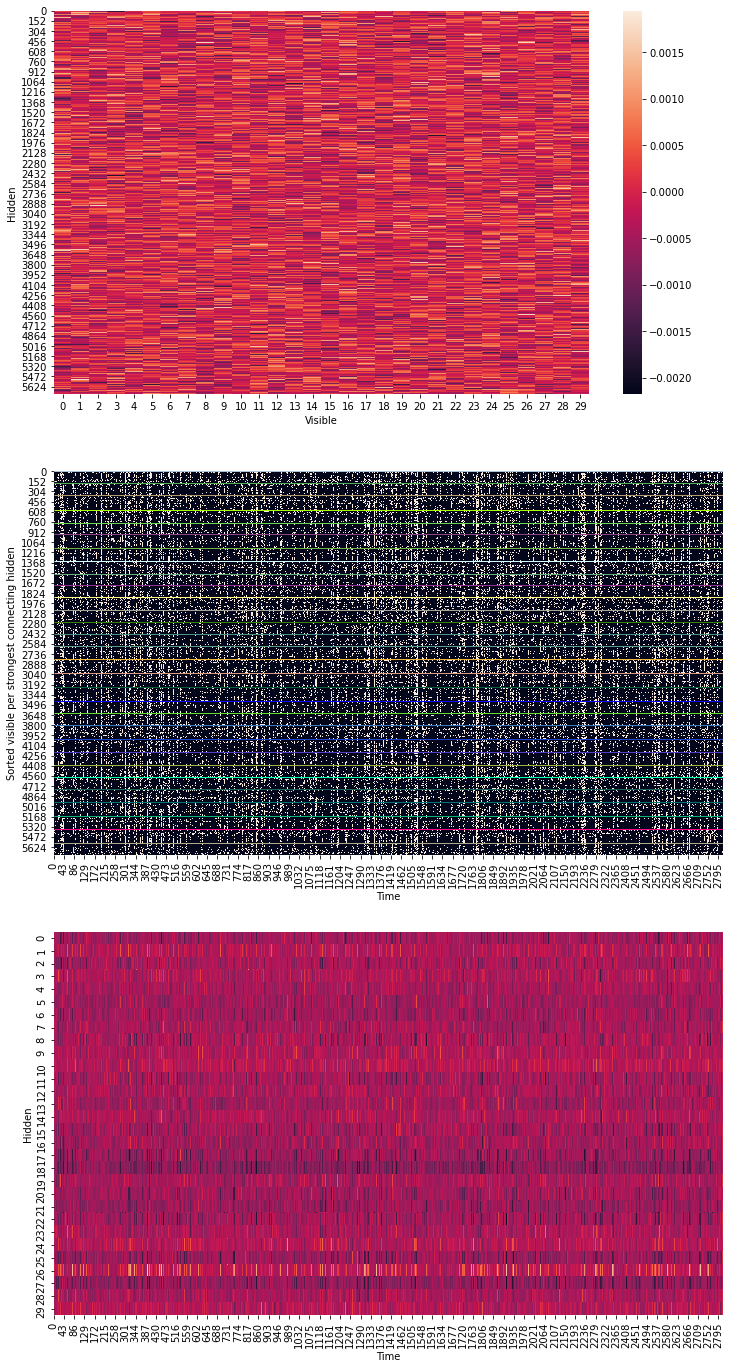

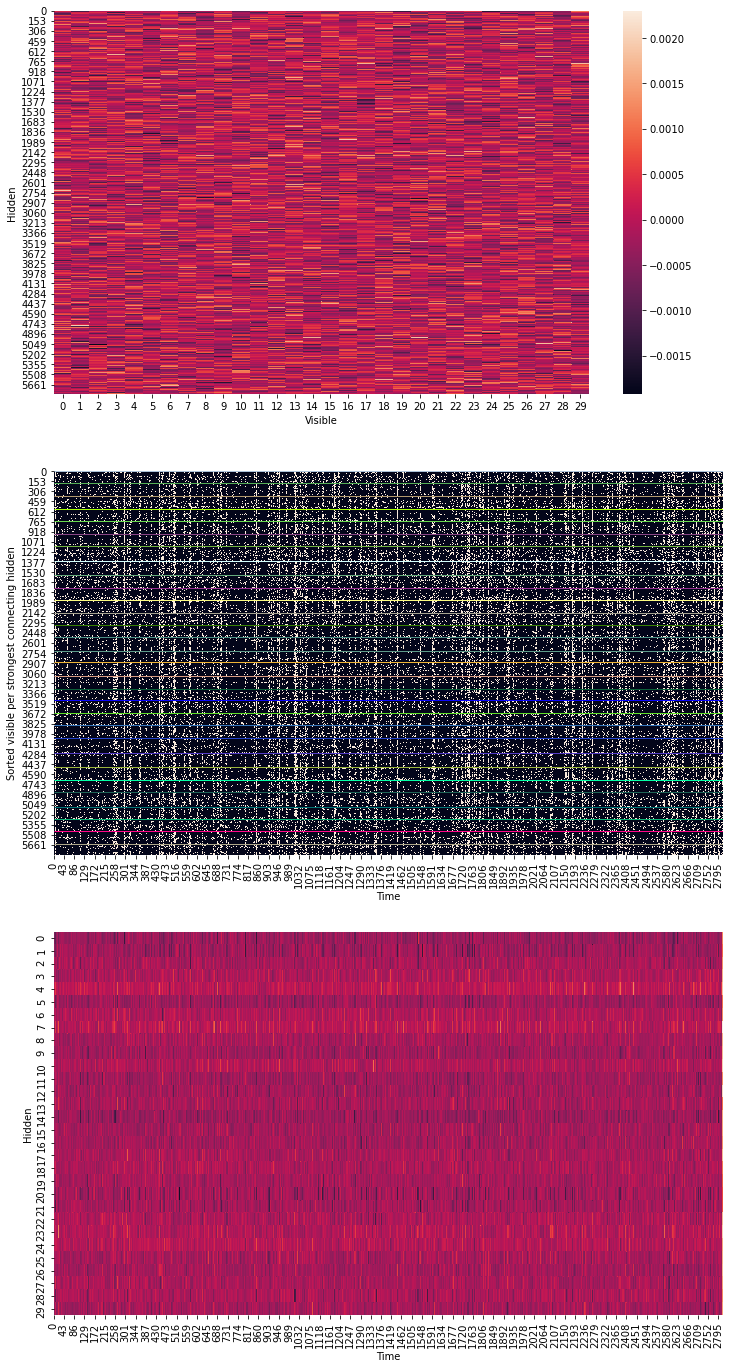

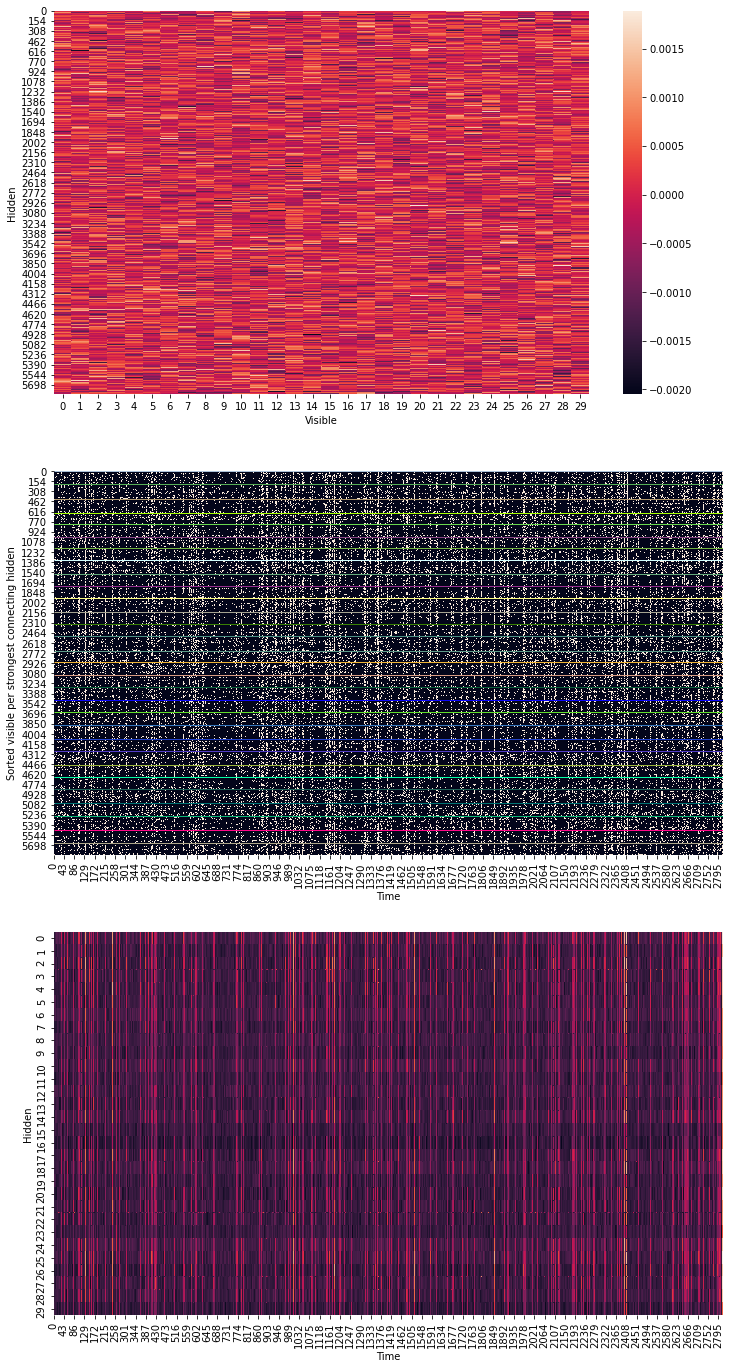

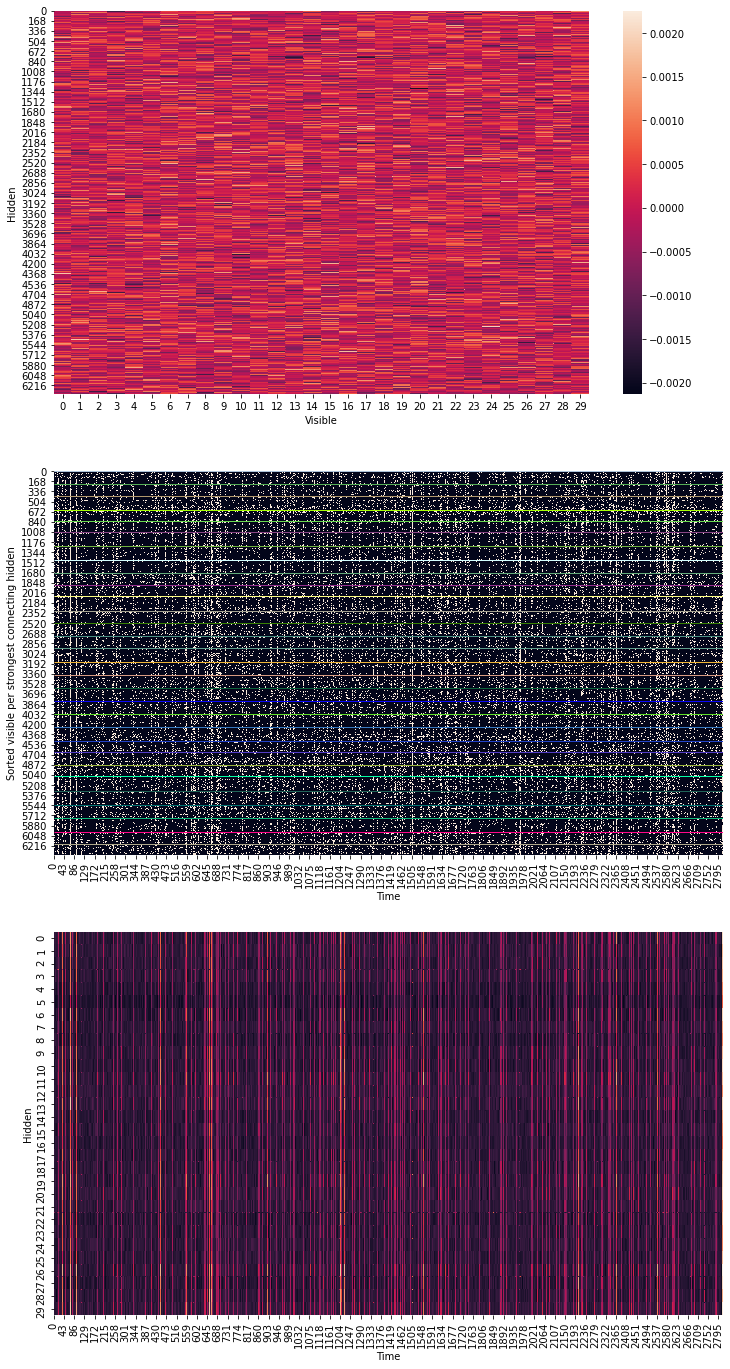

In [34]:
for i in range(0,num_data_sets-1):
    W = cRBM_parameters.param[i][0].float()
    b_V = cRBM_parameters.param[i][2].float()
    spikes = cRBM_parameters.param[i][4].float()
    T = spikes.shape[1]

    rt = torch.zeros(W.shape[0], T)
    for t in range(T):
        rt[:, t] = torch.sigmoid(torch.matmul(W, spikes[:, t]) + b_V)
    

    plot_spikes_grouped_by_HU(VH=cRBM_parameters.param[i][0], V=cRBM_parameters.param[i][4], H=rt)

##  VH, spikes grouped by strongest connecting HU and hidden unit activity of the cRTRBM

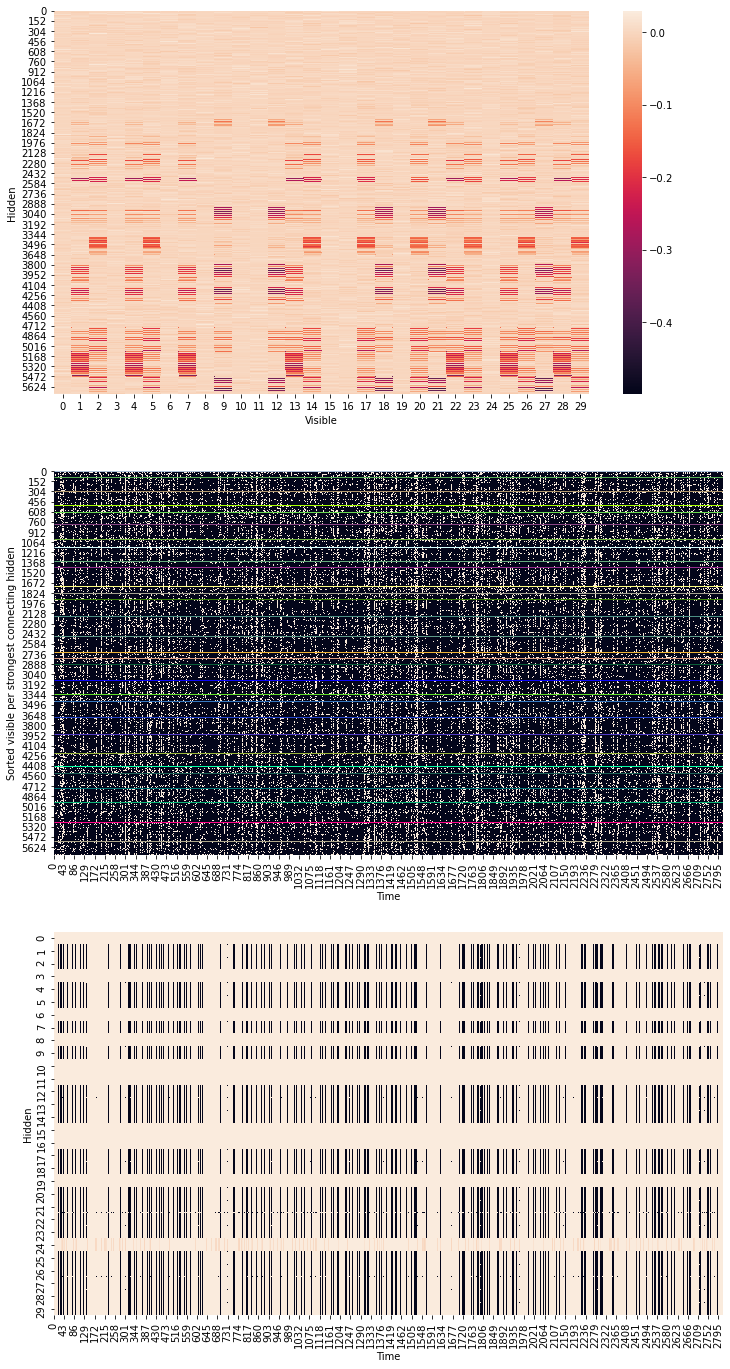

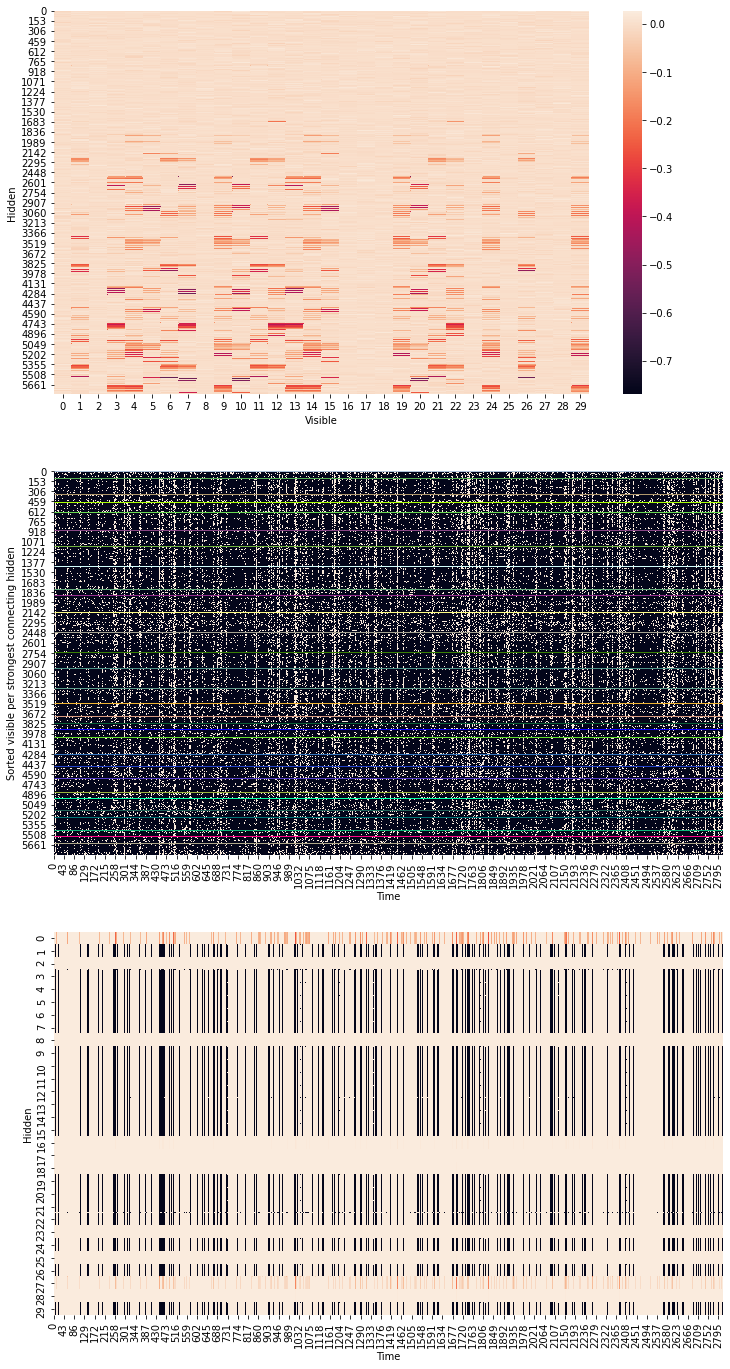

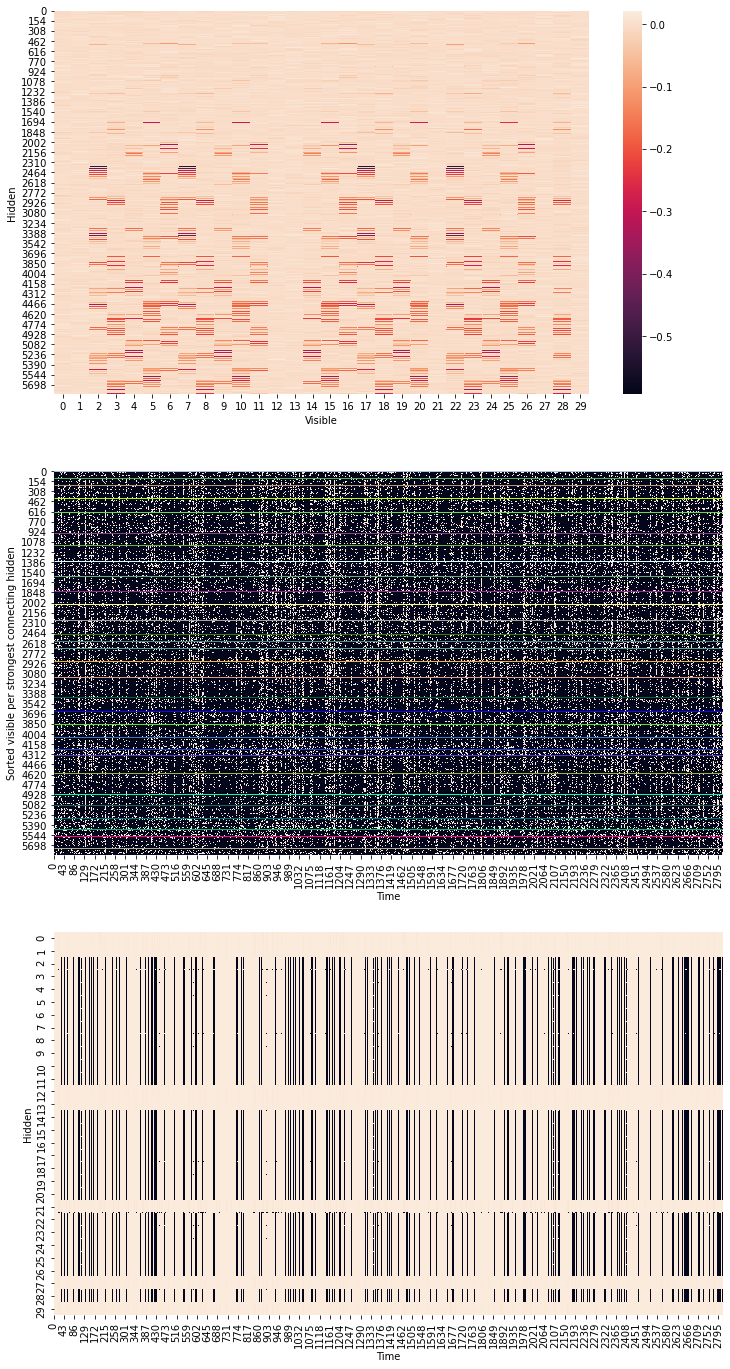

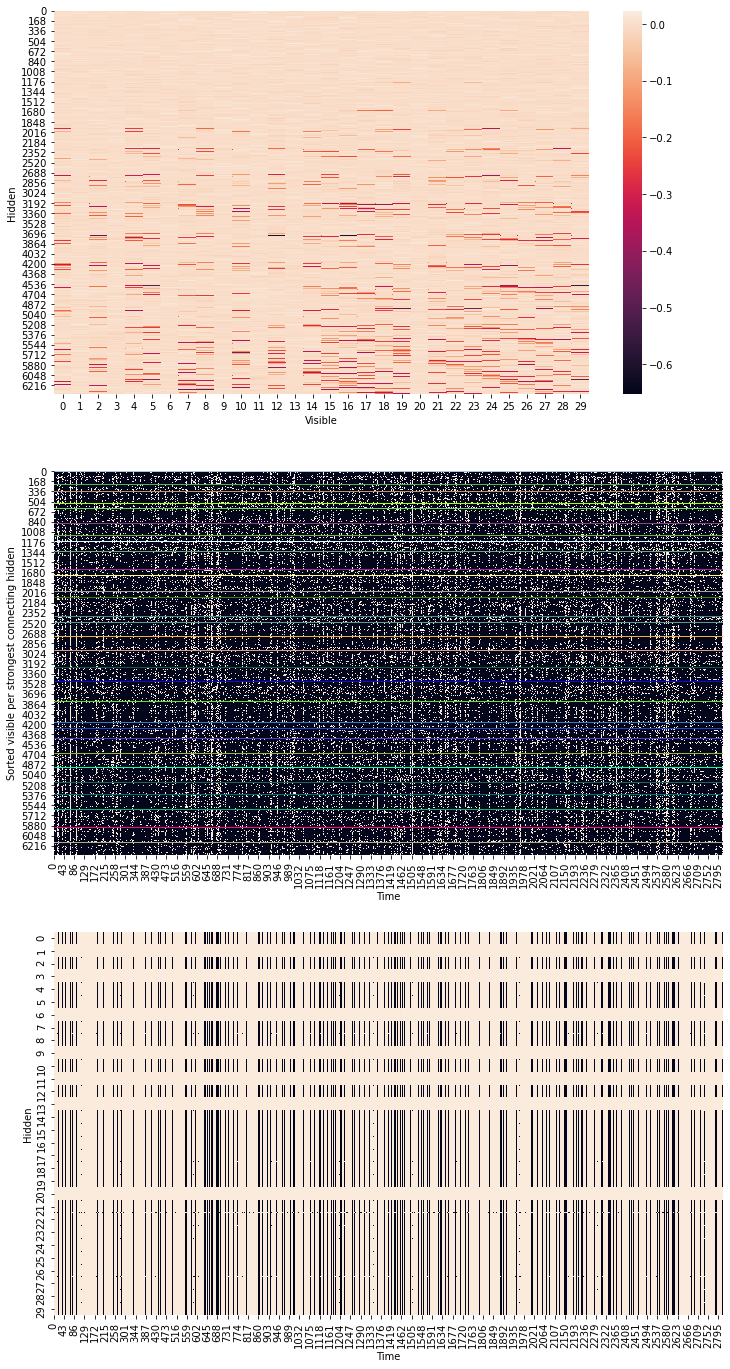

In [51]:
for i in range(0,num_data_sets-1):
    VH = cRTRBM_parameters.param[i][0]
    HH = cRTRBM_parameters.param[i][1]
    b_H = cRTRBM_parameters.param[i][3]
    b_init = cRTRBM_parameters.param[i][4]
    vt = cRTRBM_parameters.param[i][6]
    N_H, N_V = VH.shape
    T = vt.shape[1]

    rt = torch.zeros(N_H, T)
    rt[:, 0] = torch.sigmoid(torch.matmul(VH, vt[:, 0]) + b_init)
    for t in range(1, T):
        rt[:, t] = torch.sigmoid(torch.matmul(VH, vt[:, t]) + b_H + torch.matmul(HH, rt[:, t - 1]))
        
    plot_spikes_grouped_by_HU(VH=VH, V=vt, H=rt)

## Receptive field cRBM

In [68]:
print(voxel_xyz.shape, VH.shape)


torch.Size([6455, 3]) torch.Size([30, 6367])


In [62]:
torch.sum(VH[0, :] * voxel_xyz[:, 1])

RuntimeError: The size of tensor a (6367) must match the size of tensor b (6455) at non-singleton dimension 0

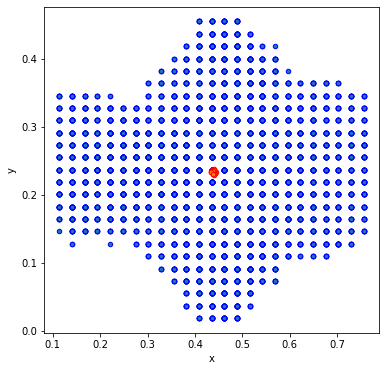

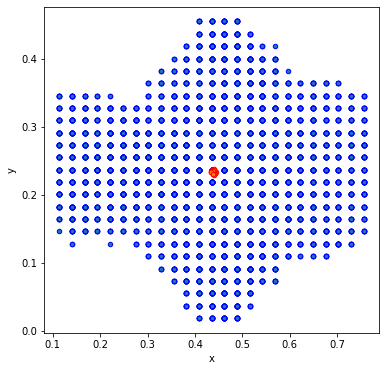

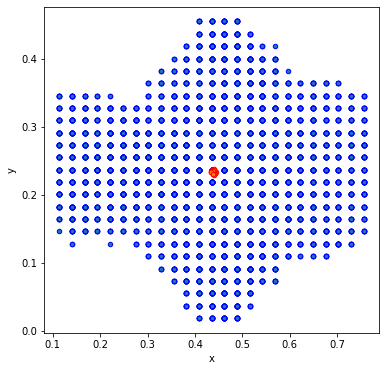

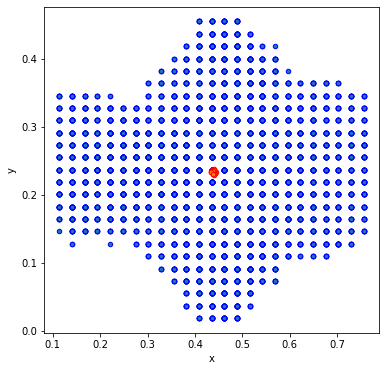

In [70]:
%matplotlib inline
import matplotlib as mpl

for subject in range(num_data_sets-1):
    VH = cRBM_parameters.param[i][0].clone()
    coordinates = cRBM_parameters.param[i][5].clone()
    
    VH[VH<0] = 0

    rf = get_hidden_mean_receptive_fields(VH, coordinates)
    fig, ax = plt.subplots(figsize=(6,6))

    ax.scatter(coordinates[:, 0], coordinates[:, 1], s =20, edgecolors = 'b')
    ax.scatter(rf[:, 0], rf[:, 1], s=20, edgecolors = 'r')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()


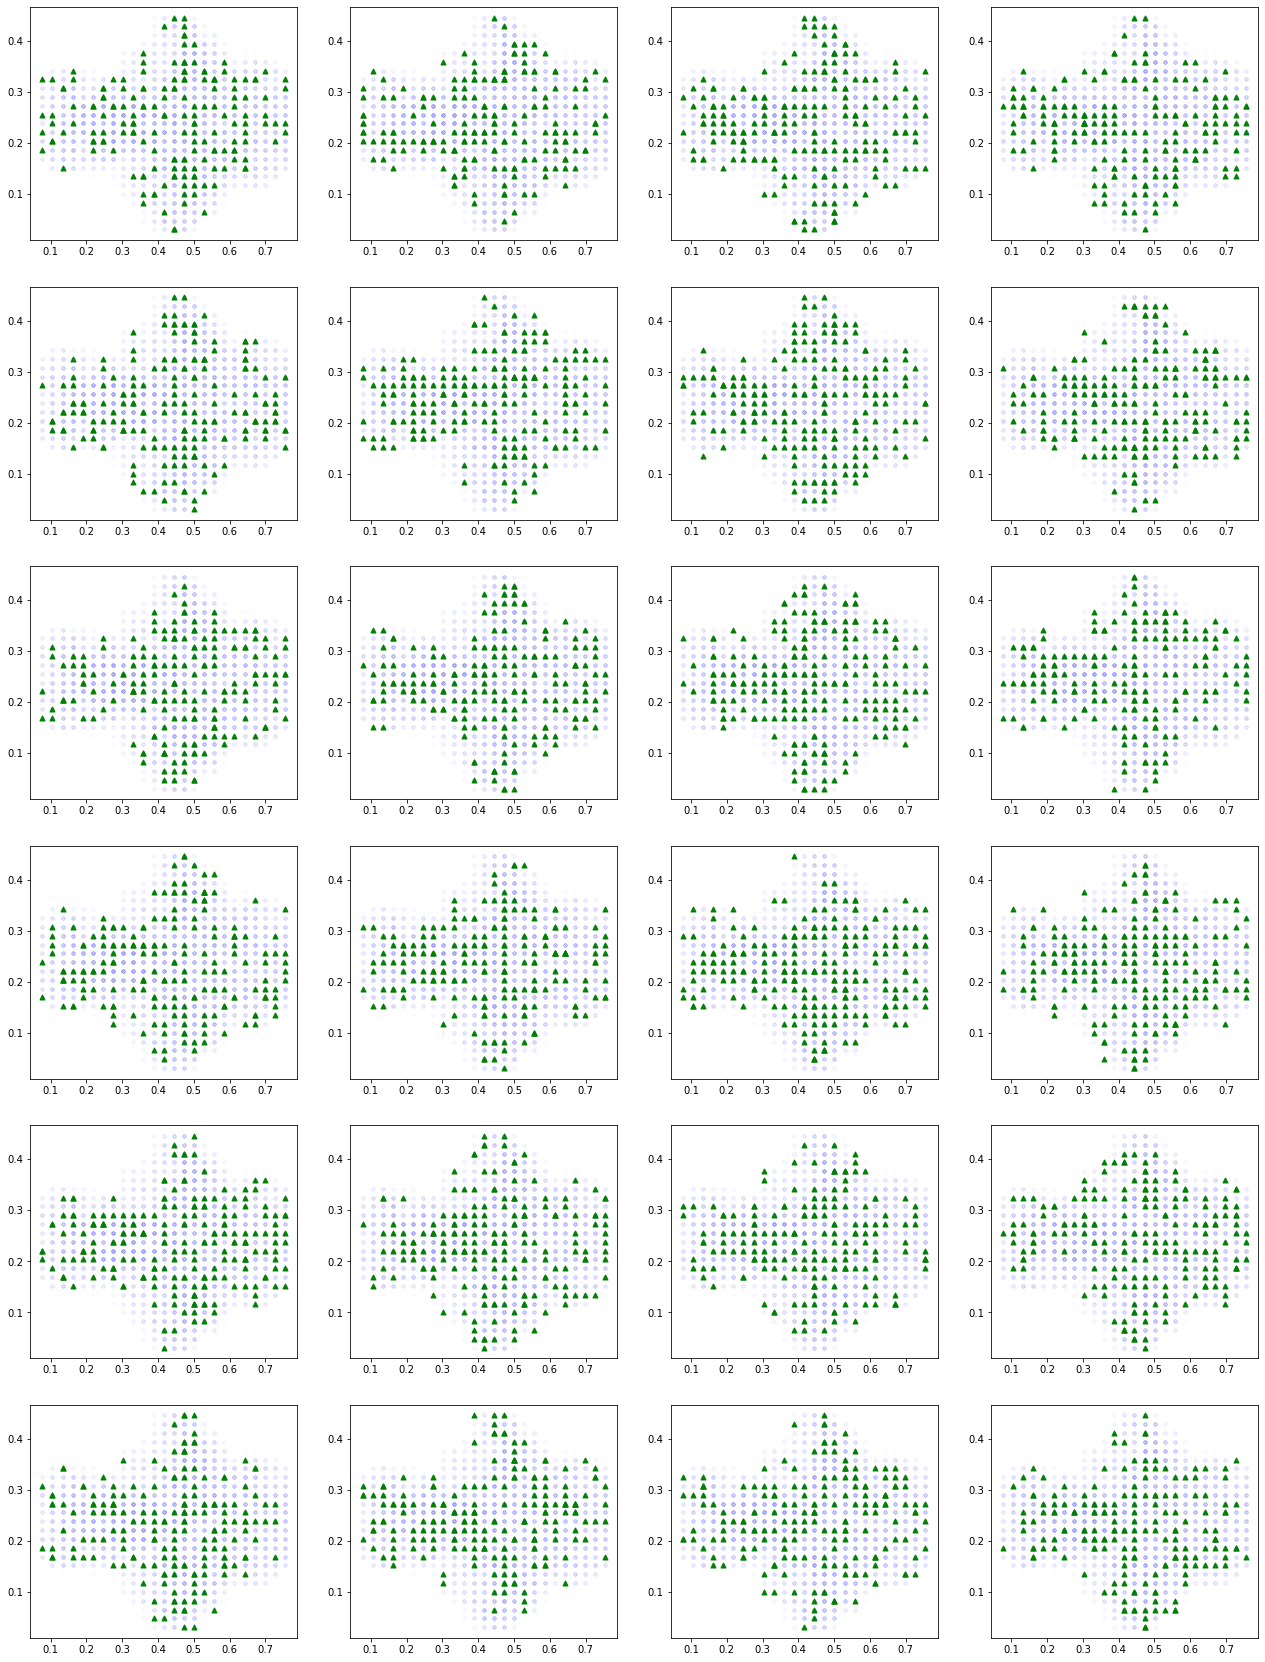

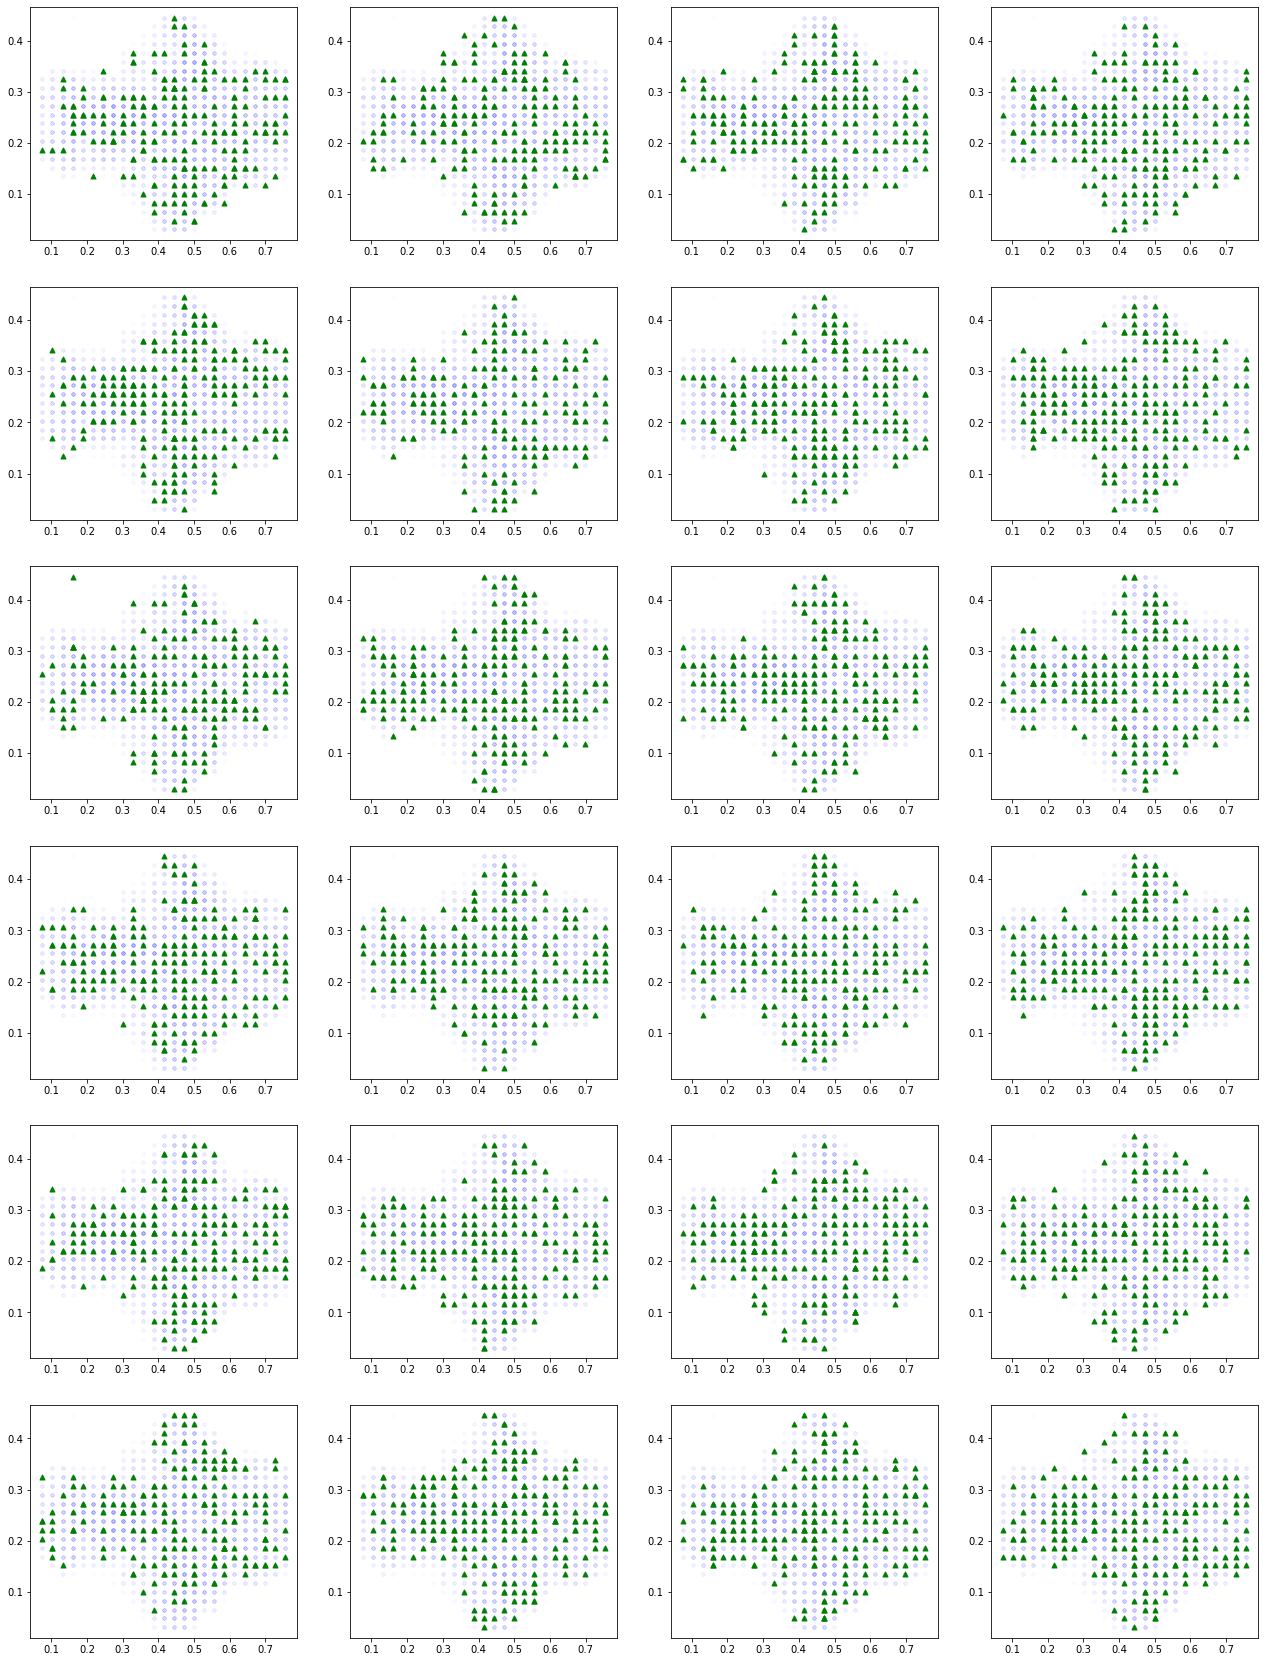

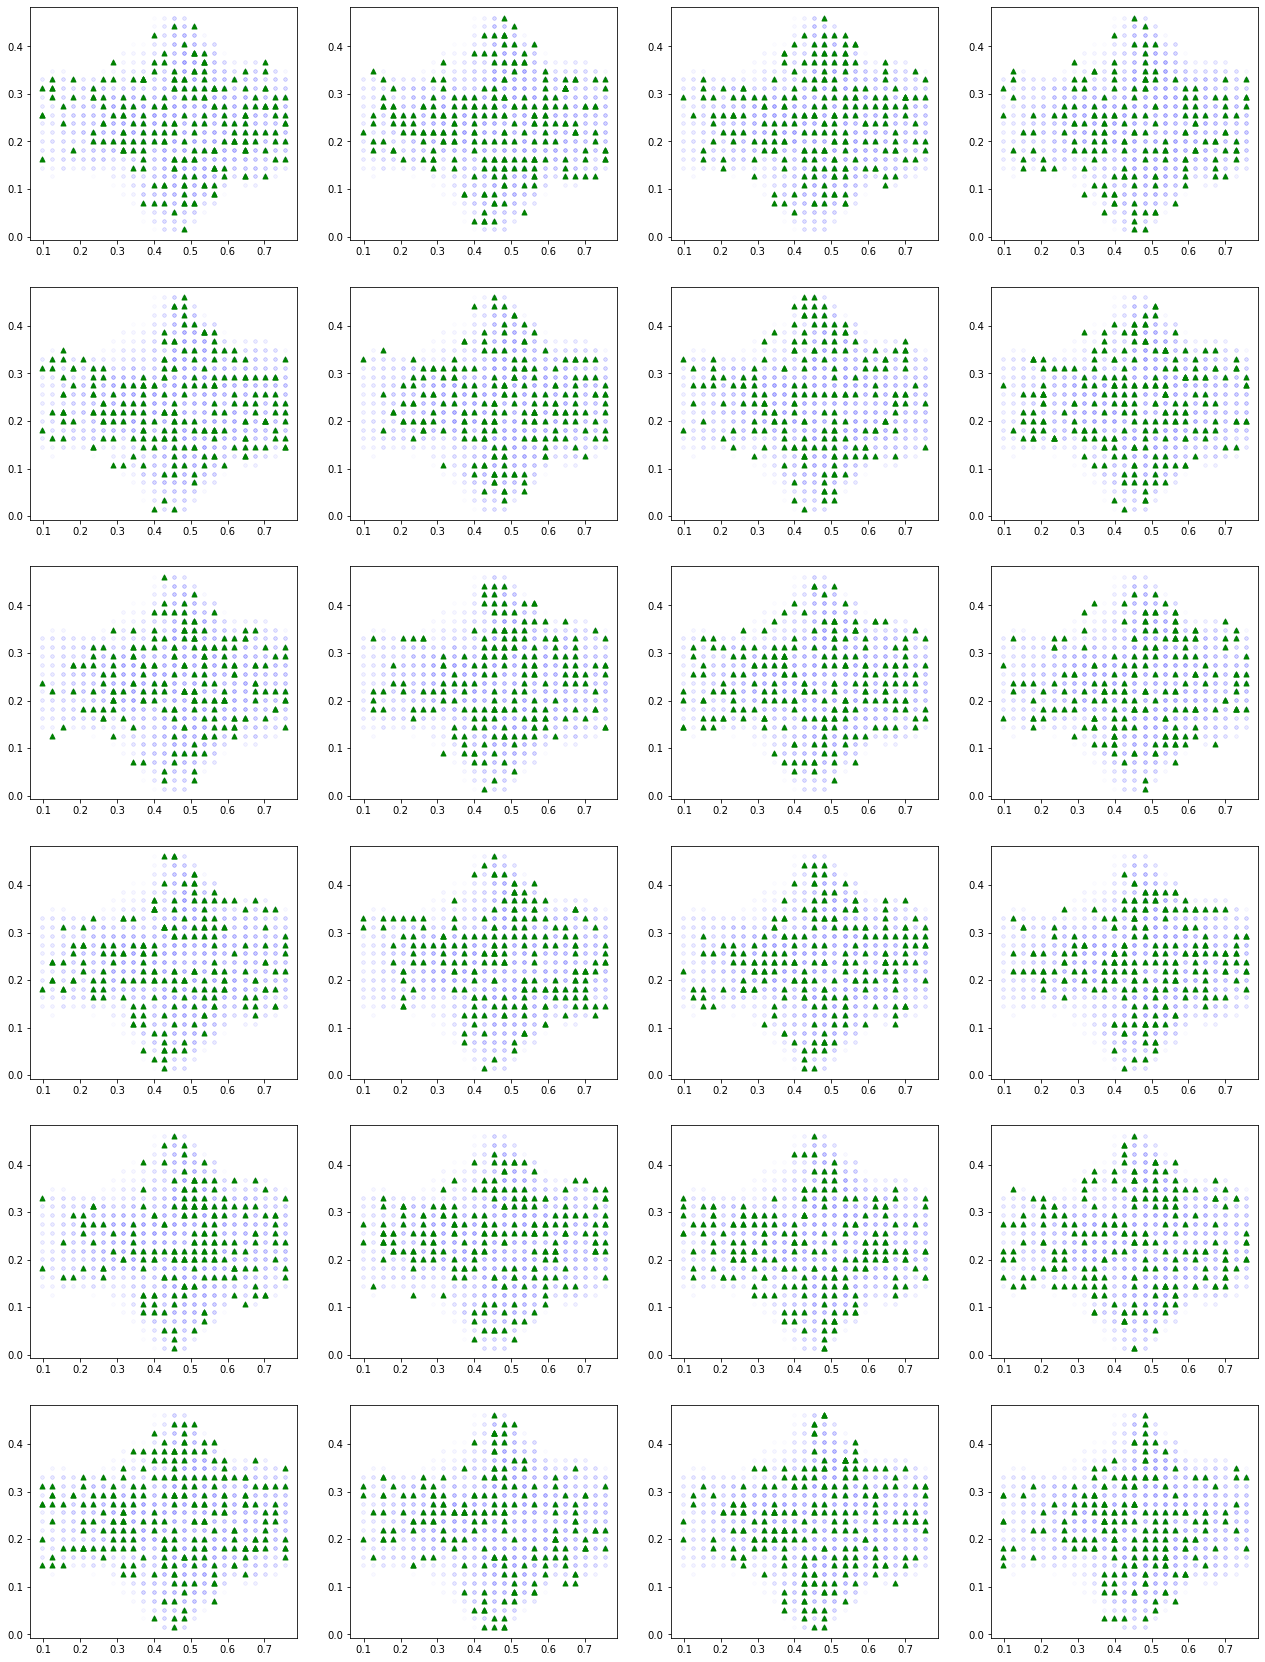

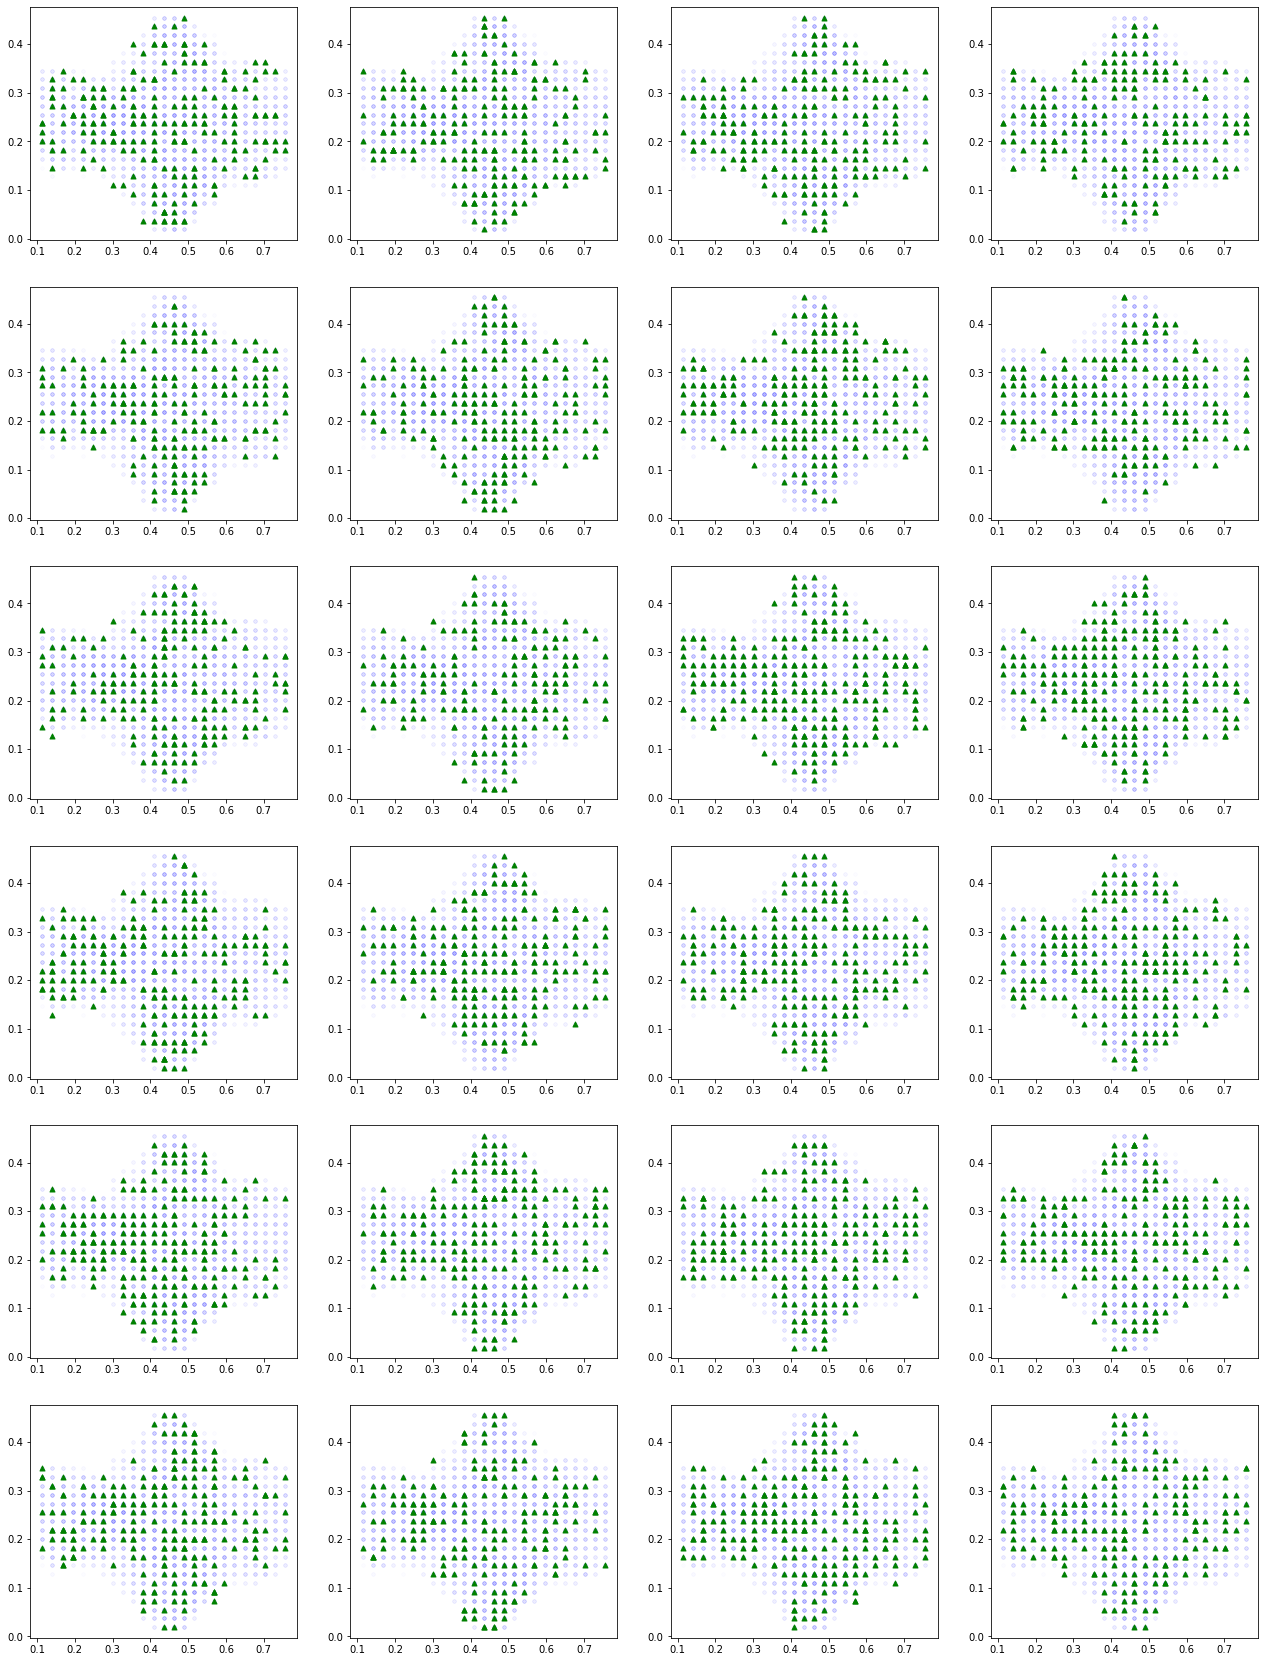

In [72]:
import matplotlib as mpl

for subject in range(num_data_sets-1):
    VH = cRBM_parameters.param[subject][0].detach().clone()
    coordinates = cRBM_parameters.param[subject][5].detach().clone()
    fig, ax = plt.subplots(6, 4, figsize=(22, 30))
    max_hidden_connection = torch.max(VH, 0)[1]
    strong_thresh = 0.2 * torch.std(VH)
    h = 0
    for i in range(6):
        for j in range(4):
            idx_p = (max_hidden_connection==h)*(VH[h,:] >  strong_thresh)
            idx_m = (max_hidden_connection==h)*(VH[h,:] < -strong_thresh)
            #idx_not_p = (max_hidden_connection==h)*((VH[h,:] <=  strong_thresh) & (VH[h,:]>0))
            #idx_not_m = (max_hidden_connection==h)*((VH[h,:] >= -strong_thresh) & (VH[h,:]<0))
            
            ax[i,j].scatter(coordinates[:,0], coordinates[:,1], s=15, color = 'blue', alpha=0.01)

            ax[i,j].scatter(coordinates[idx_p,0], coordinates[idx_p,1], s=25, color = 'green', marker='^')
            ax[i,j].scatter(coordinates[idx_m,0], coordinates[idx_m,1], s=25, color = 'red', marker="v")

            #ax[i,j].scatter(coordinates[idx_not_p,0], coordinates[idx_not_p,1], s=25, color = 'red', marker='^', alpha=0.3)
            #ax[i,j].scatter(coordinates[idx_not_m,0], coordinates[idx_not_m,1], s=25, color = 'red', marker="v", alpha=0.3)
                
            h +=1
            
    #mpl.style.use('seaborn')

## Receptive field cRTRBM

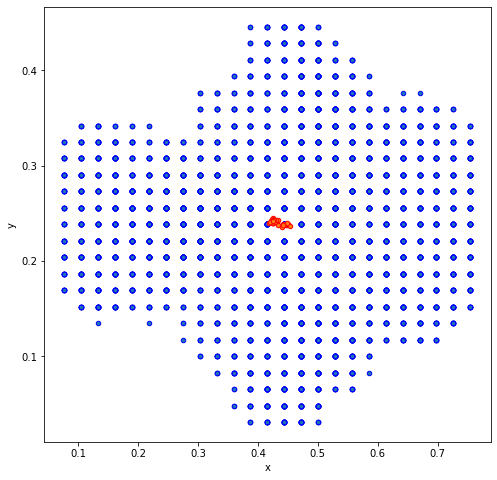

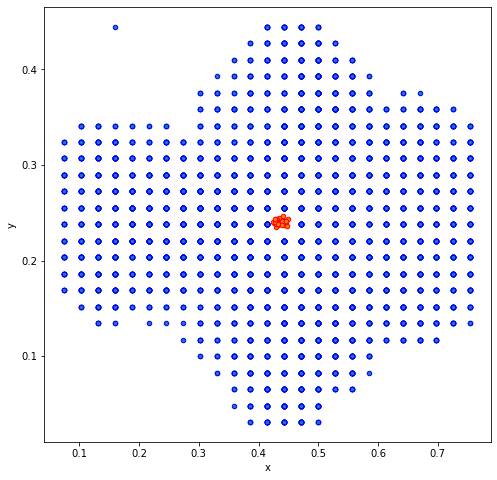

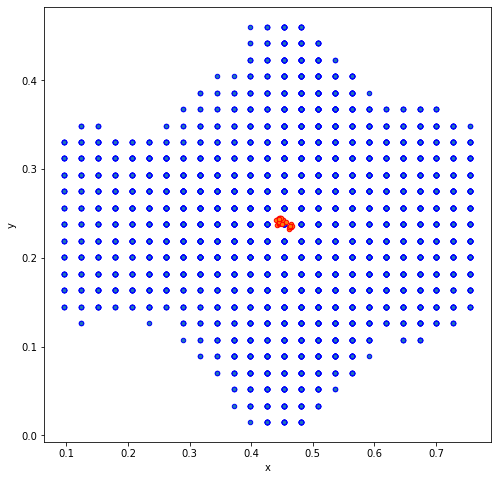

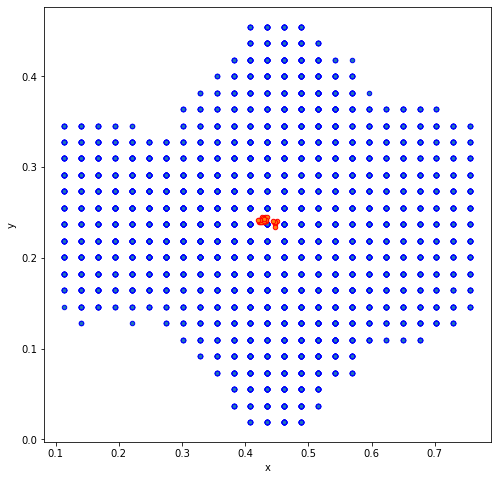

In [74]:
%matplotlib inline
import matplotlib as mpl

for subject in range(num_data_sets-1):
    VH = cRTRBM_parameters.param[subject][0].clone()
    coordinates = cRTRBM_parameters.param[subject][7].clone()

    VH[VH<0] = 0

    rf = get_hidden_mean_receptive_fields(VH, coordinates)
    fig, ax = plt.subplots(figsize=(8,8))

    ax.scatter(coordinates[:, 0], coordinates[:, 1], s =20, edgecolors = 'b')
    ax.scatter(rf[:, 0], rf[:, 1], s=20, edgecolors = 'r')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()



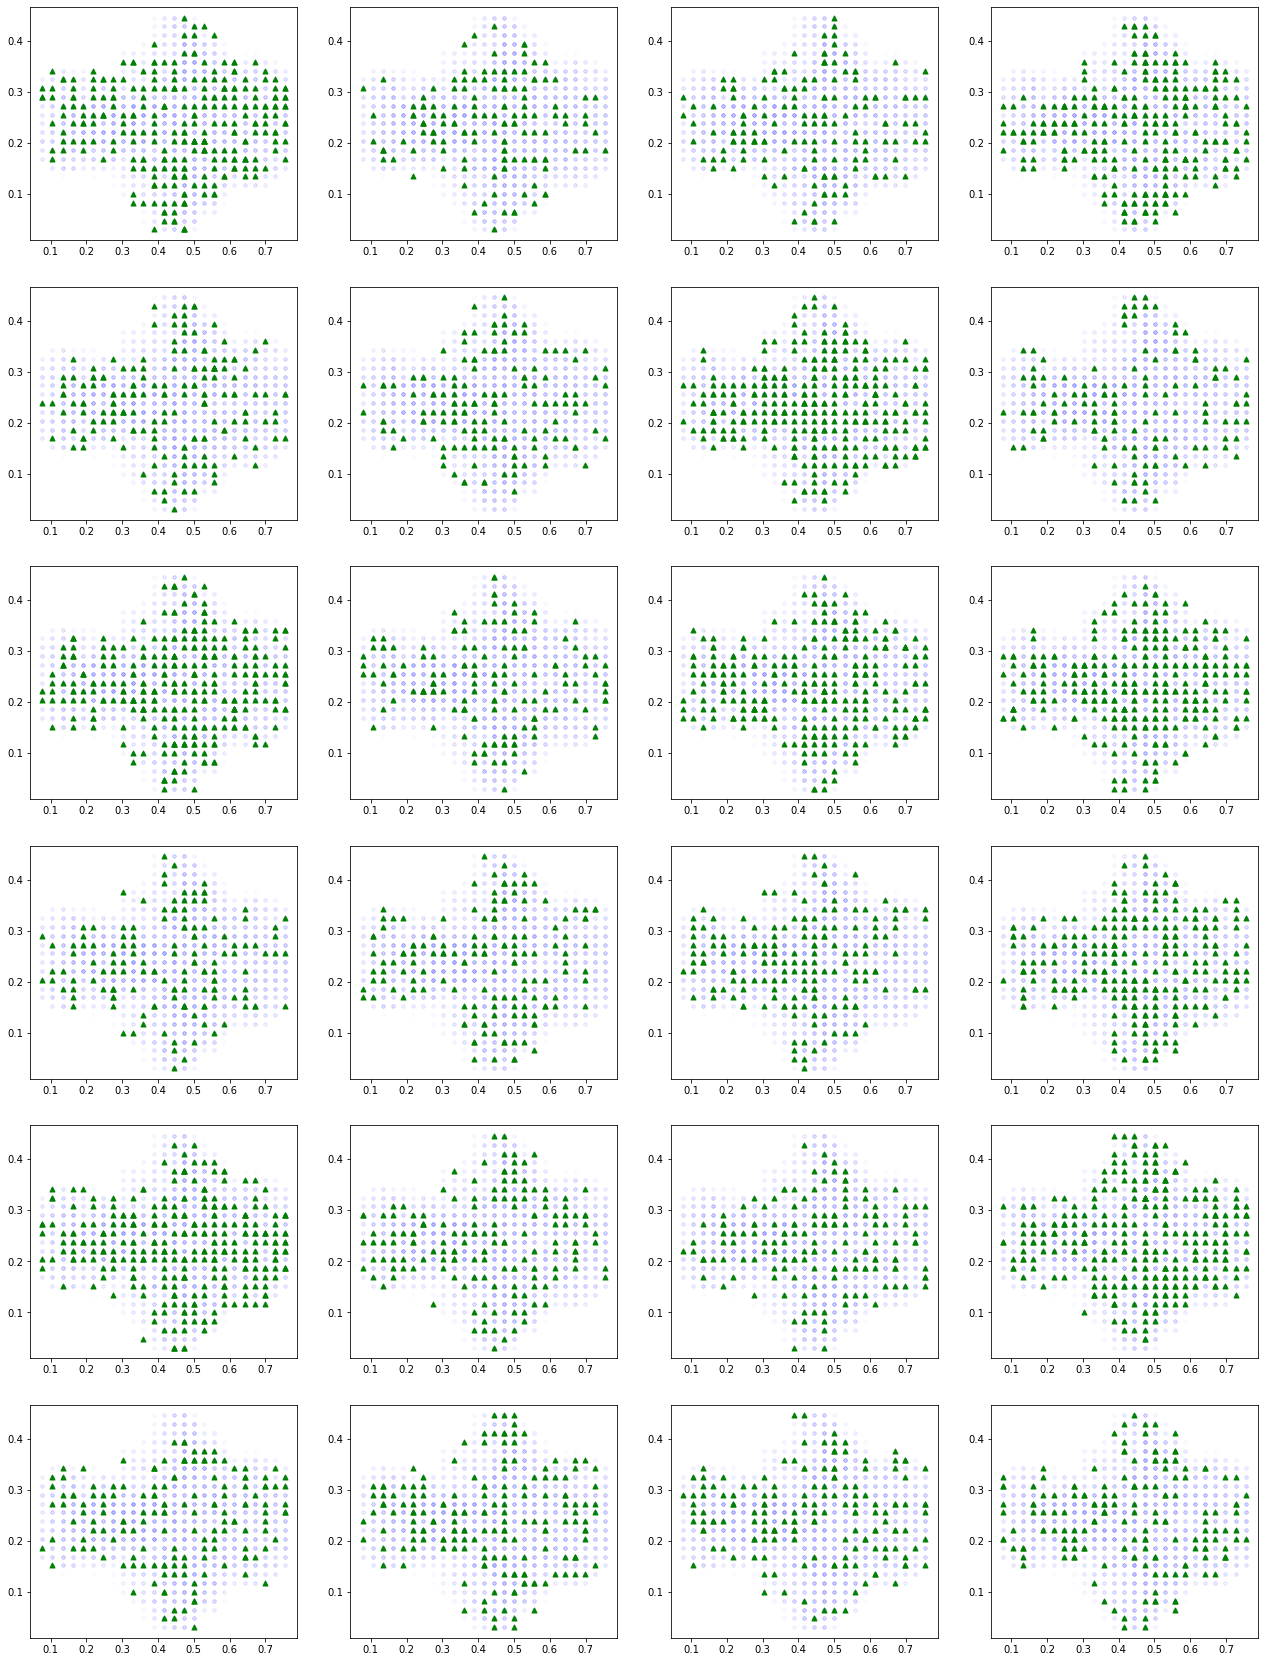

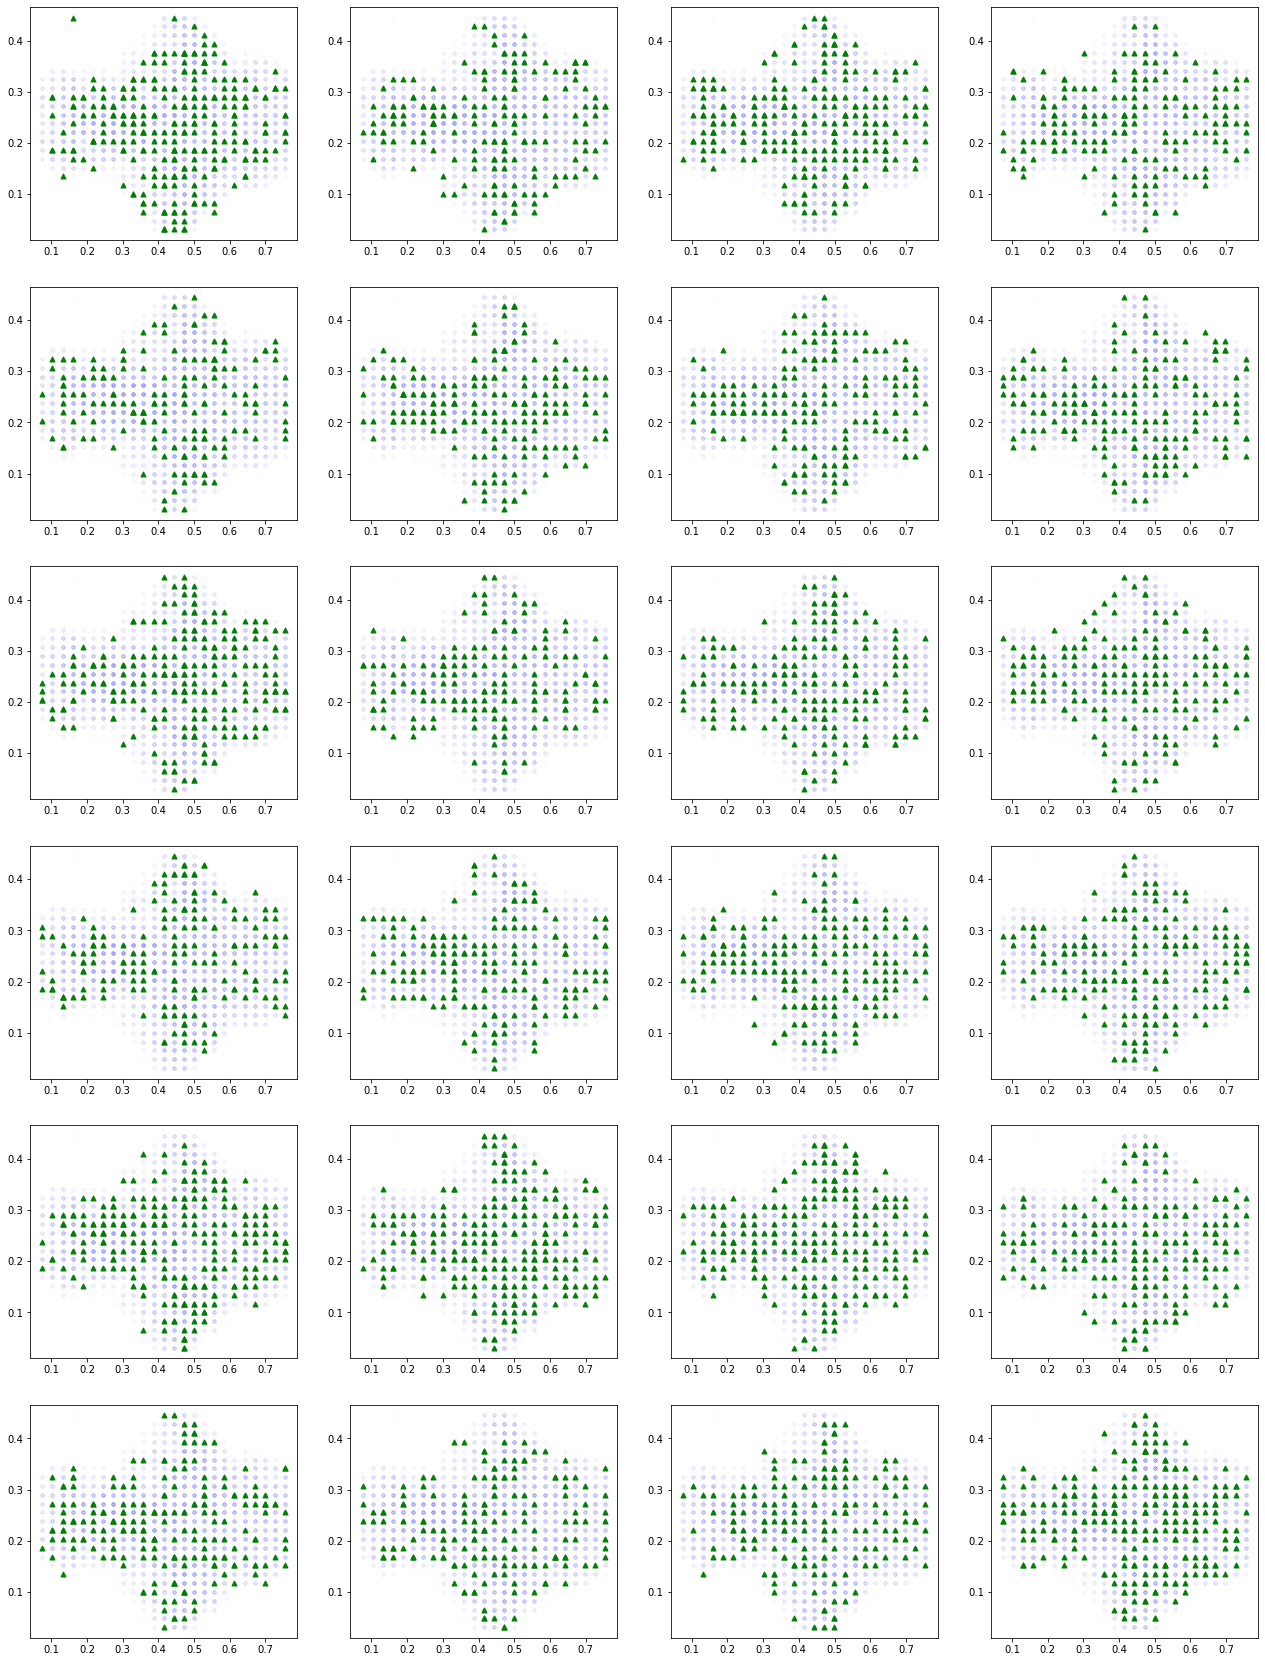

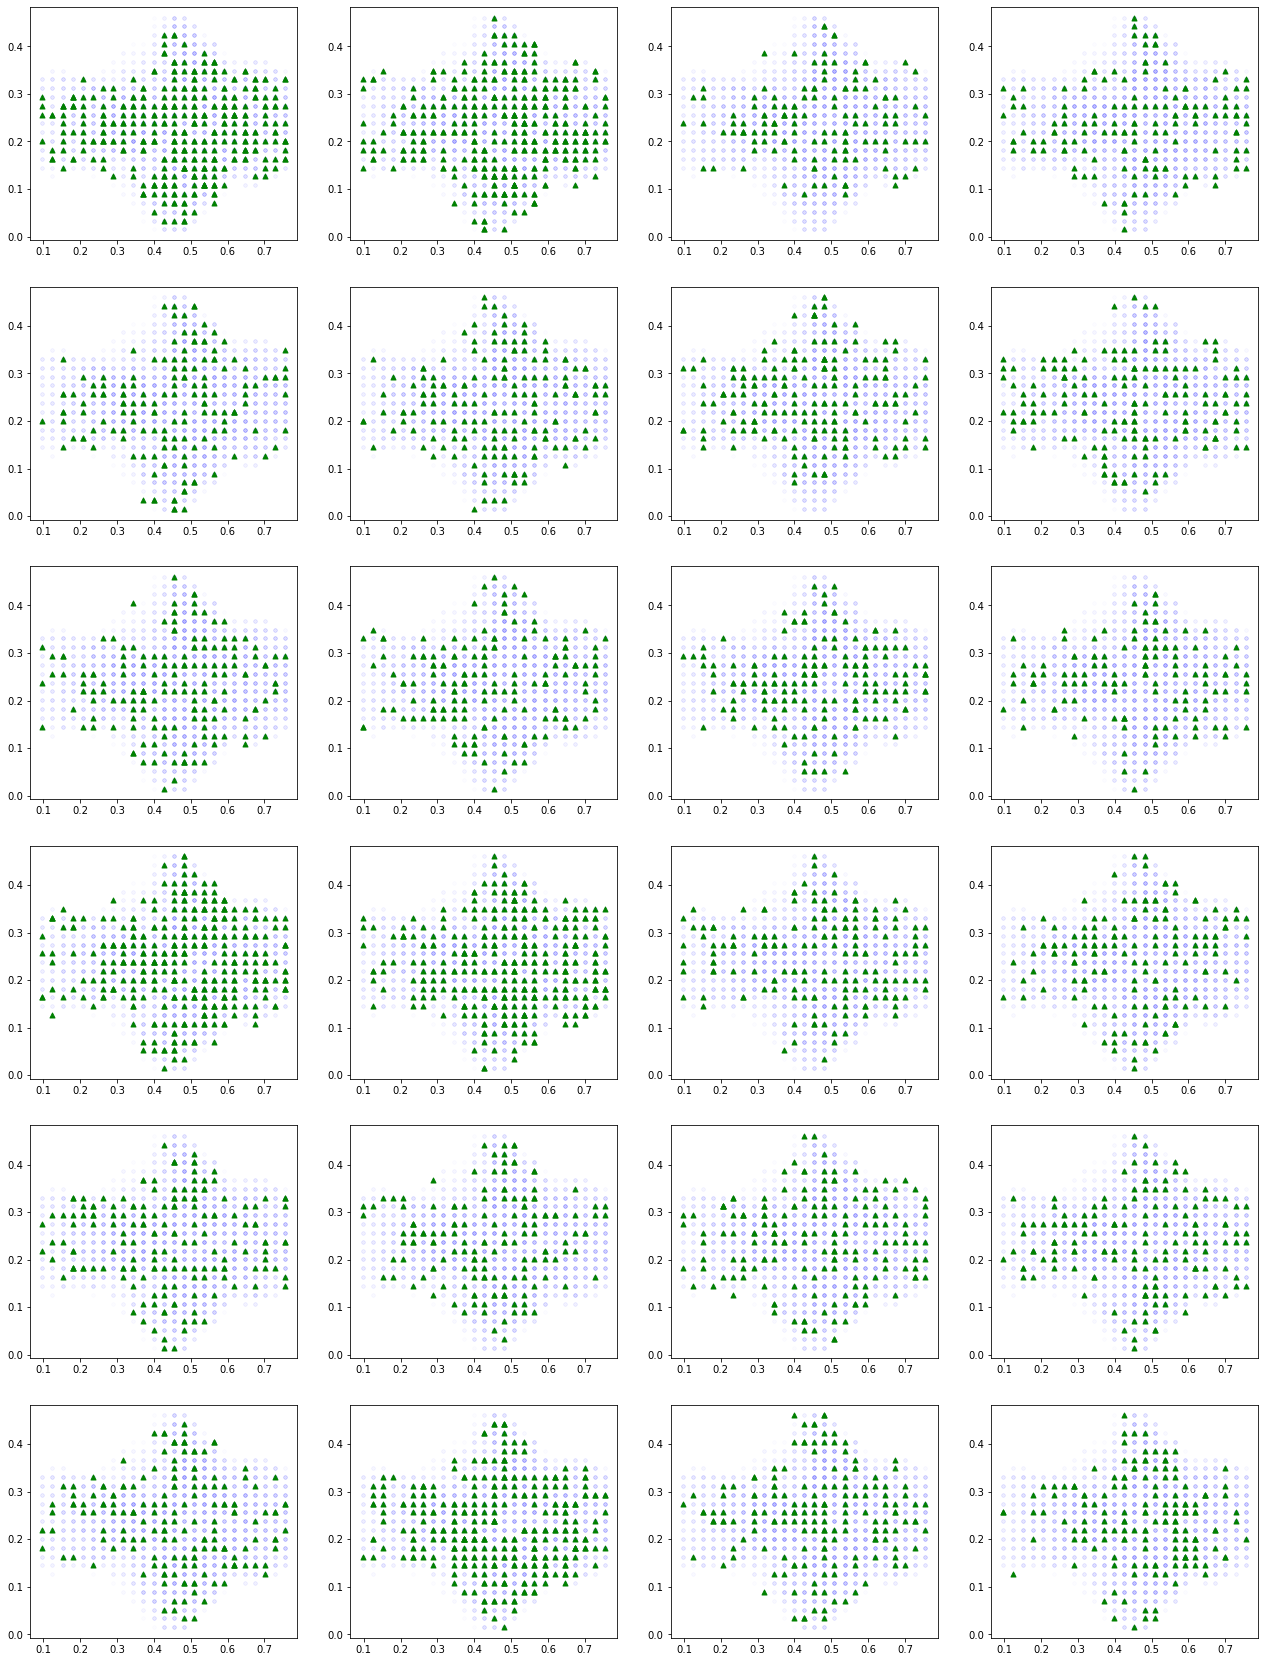

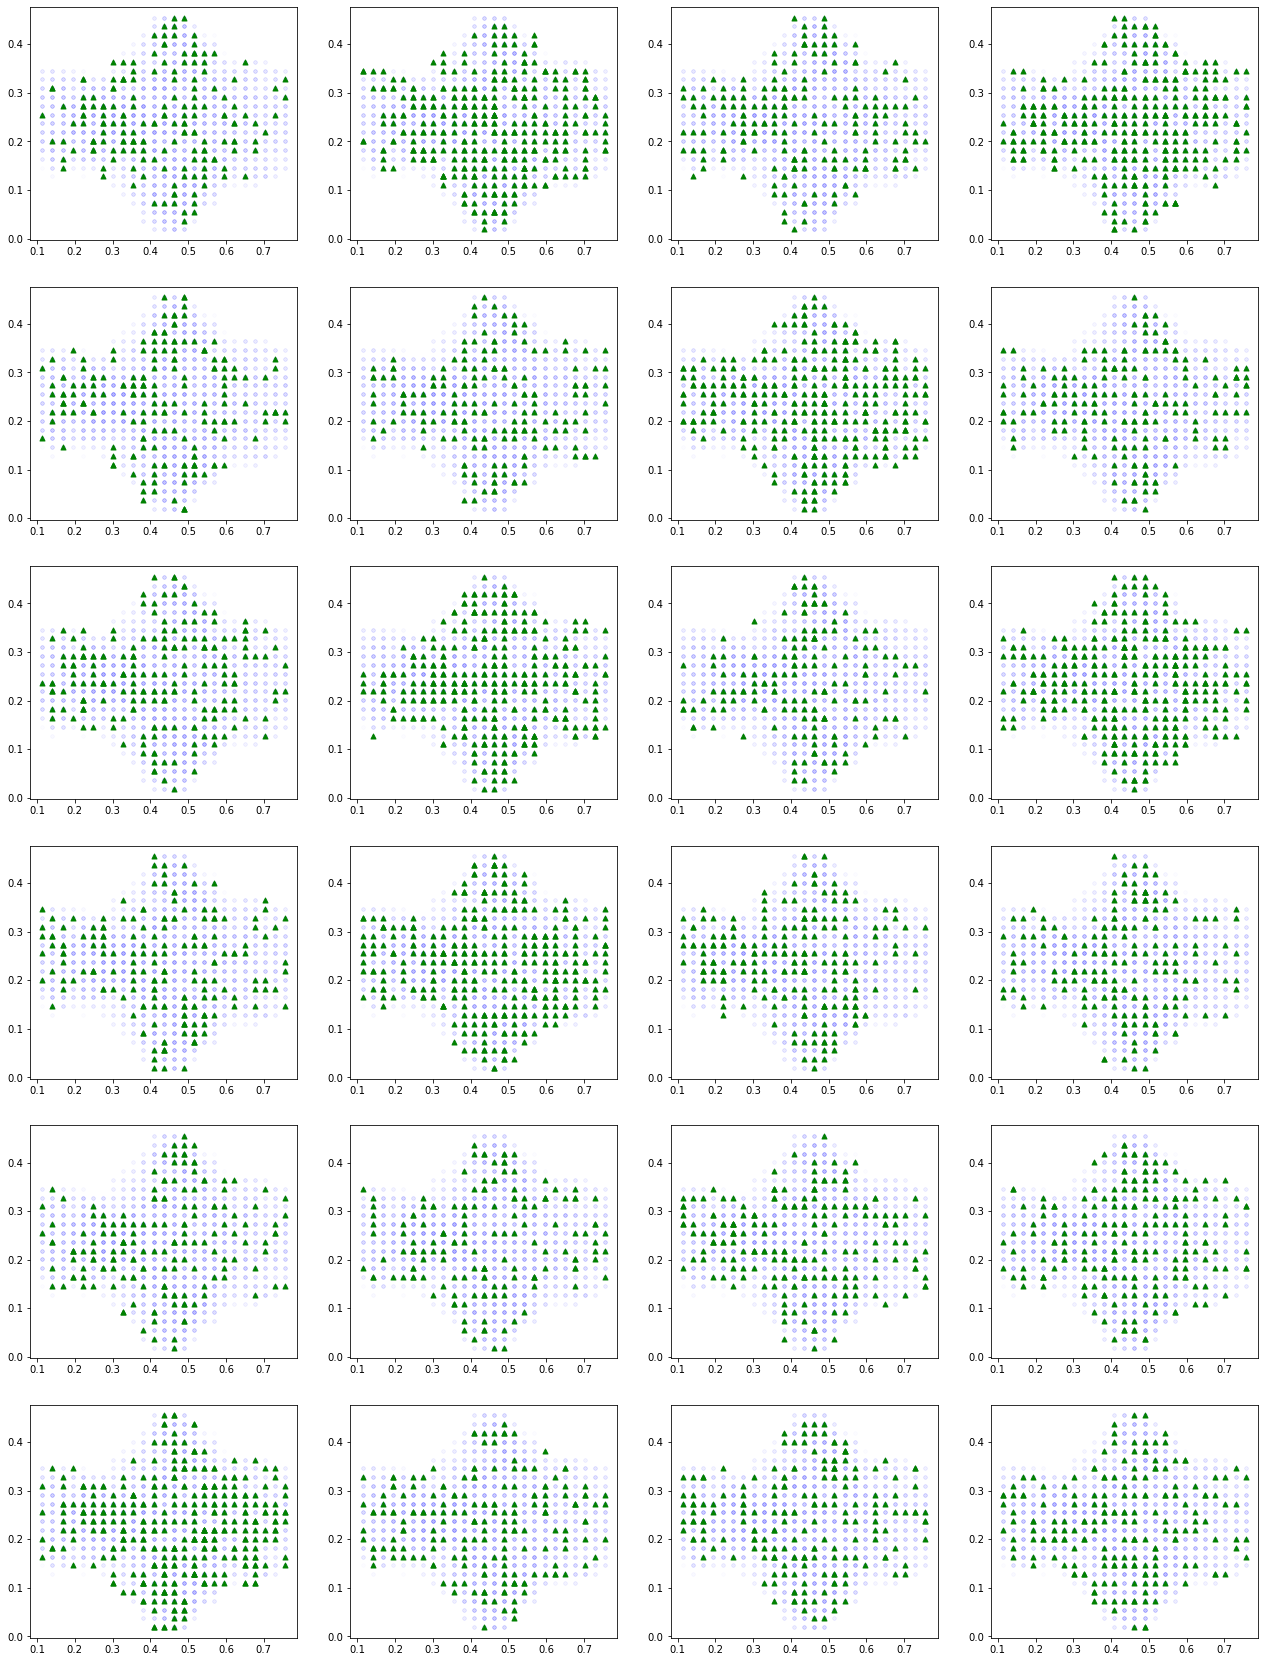

In [75]:
for subject in range(num_data_sets-1):
    VH = cRTRBM_parameters.param[subject][0].clone()
    coordinates = cRTRBM_parameters.param[subject][7].clone()
    fig, ax = plt.subplots(6, 4, figsize=(22, 30))
    max_hidden_connection = torch.max(VH, 0)[1]
    strong_thresh = 0.2 * torch.std(VH)
    h = 0
    for i in range(6):
        for j in range(4):
            idx_p = (max_hidden_connection==h)*(VH[h,:] >  strong_thresh)
            idx_m = (max_hidden_connection==h)*(VH[h,:] < -strong_thresh)
            #idx_not_p = (max_hidden_connection==h)*((VH[h,:] <=  strong_thresh) & (VH[h,:]>0))
            #idx_not_m = (max_hidden_connection==h)*((VH[h,:] >= -strong_thresh) & (VH[h,:]<0))
            
            ax[i,j].scatter(coordinates[:,0], coordinates[:,1], s=15, color = 'blue', alpha=0.01)

            ax[i,j].scatter(coordinates[idx_p,0], coordinates[idx_p,1], s=25, color = 'green', marker='^')
            ax[i,j].scatter(coordinates[idx_m,0], coordinates[idx_m,1], s=25, color = 'red', marker="v")

            #ax[i,j].scatter(coordinates[idx_not_p,0], coordinates[idx_not_p,1], s=25, color = 'red', marker='^', alpha=0.3)
            #ax[i,j].scatter(coordinates[idx_not_m,0], coordinates[idx_not_m,1], s=25, color = 'red', marker="v", alpha=0.3)
                
            h +=1
            
    #mpl.style.use('seaborn')

In [76]:
#del create_plot, line_between_two_neurons
#from utils.visualize_hidden_network import create_plot

create_plot(crtrbm.W, crtrbm.W_acc, rf, coordinates, dy=0.1, markersize_visibles=50, hiddens_radius=0.04)

NameError: name 'crtrbm' is not defined

## Compare the moments of the cRBM and the cRTRBM

In [ ]:
plot_compare_moments(rbm, rtrbm, train_data, test_data, MC_chains=300, chain=50, pre_gibbs_k=100, gibbs_k=20)

### Correlations

In [ ]:
C_v = correlation_matrix(spikes)
C_r = correlation_matrix(crtrbm.visible_to_hidden(spikes.float()))

fig, axes = plt.subplots(2,1, figsize=(8,12))
sns.heatmap(C_v, ax = axes[0])
axes[0].set_xlabel("neuron #",fontsize=20)
axes[0].set_ylabel("neuron #",fontsize=20)

sns.heatmap(C_r, ax = axes[1])
axes[1].set_xlabel("Hidden #",fontsize=20)
axes[1].set_ylabel("Hidden #",fontsize=20)

plt.show()


Cross-correlation

In [ ]:
C_v = cross_correlation(spikes)
C_r = cross_correlation(crtrbm.visible_to_hidden(spikes.float()))

fig, axes = plt.subplots(2,1, figsize=(8,12))
sns.heatmap(C_v, ax = axes[0])
axes[0].set_xlabel("neuron #",fontsize=20)
axes[0].set_ylabel("neuron #",fontsize=20)

sns.heatmap(C_r, ax = axes[1])
axes[1].set_xlabel("Hidden #",fontsize=20)
axes[1].set_ylabel("Hidden #",fontsize=20)

plt.show()

In [ ]:
plot_weights_log_distribution_compare(crtrbm.W.T, crtrbm.W_acc.T, label1='VH', label2='HH')

In [ ]:
crtrbm.b_H

In [ ]:
plt.scatter(torch.mean(crtrbm.W,0), torch.mean(spikes,1))

### Receptive field

In [ ]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

VH = crtrbm.W.clone()
VH[VH<0] = 0

rf = get_hidden_mean_receptive_fields(VH, coordinates)
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(coordinates[:, 0], coordinates[:, 1], s =20, edgecolors = 'b')
ax.scatter(rf[:, 0], rf[:, 1], s=20, edgecolors = 'r')

ax.set_xlabel('x')
ax.set_ylabel('y')


RF of all hiddens are in the middle of the graph. Now let do the same approach as in the thesis of thijs: color code each neuron according to its strongest-connecting HU. 

In [ ]:
%matplotlib inline
N_V = N
VH = crtrbm.W.detach().clone()
stongest_connecting_HU = torch.zeros(N_V)

for i in range(N_V):
    # returns the index where the strongest connecting HU per visible is according to VH
    stongest_connecting_HU[i] = torch.argmax(torch.abs(VH[:,i]))
    
xy_visibles_per_HU = []

# sort the visibels on their stongest connection HU 
idx = torch.argsort(stongest_connecting_HU)
num = torch.zeros(N_H+1)
xy_mean_v_p_HU = torch.zeros(N_H, 3)

for i in range(N_H):
    # determine how many visibles are connected to hidden i
    num[i+1] = num[i] + torch.count_nonzero(stongest_connecting_HU == i)
    xy_visibles_per_HU.append(coordinates[ idx[int(num[i]) : int(num[i+1])] , :])
    xy_mean_v_p_HU[i,:] = torch.mean(coordinates[i],0)

In [ ]:
import matplotlib.colors as colors
from ipywidgets import interact
import ipywidgets as widgets
%matplotlib notebook

colors_list = list(colors._colors_full_map.values())
fig, ax = plt.subplots(figsize=(8,8))

def plot_xy_visibles_per_HU(i):
    ax.scatter(coordinates[:, 0], coordinates[:, 1], s =20, color = colors_list[0])
    ax.scatter(xy_visibles_per_HU[i][:,0], xy_visibles_per_HU[i][:,1], s=18, color=colors_list[20 * (i+1)], edgecolors = 'k', linewidths = 4)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    
interact(plot_xy_visibles_per_HU, i = widgets.IntSlider(min=0, max=(N_H-1), value=0))


In [ ]:
# all connections where abs(W) > threshold
%matplotlib inline
th = 1
VH = crtrbm.W.detach().clone()

VH[(torch.abs(VH)<th)] = 0
xy_visibles_per_HU_th = []

for i in range(N_H):
    idx = torch.where(VH[i,:] != 0)[0]
    xy_visibles_per_HU_th.append(coordinates[idx,:])

In [ ]:
%matplotlib notebook
colors_list = list(colors._colors_full_map.values())
fig, ax = plt.subplots(figsize=(8,8))

def plot_xyz_visibles_per_HU_th(i):
#for i in range(N_H):
    ax.scatter(coordinates[:, 0], coordinates[:, 1], s =20, color = colors_list[0])
    ax.scatter(xy_visibles_per_HU_th[i][:,0], xy_visibles_per_HU_th[i][:,1], s=20, color=colors_list[20 * (i+1)], edgecolors = 'k', linewidths = 4)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

interact(plot_xyz_visibles_per_HU_th, i = widgets.IntSlider(min=0, max=(N_H-1), value=0))
